In [4]:
import sys
import datacube
import numpy as np
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_dask import create_local_dask_cluster
from dea_plotting import xr_animation
from dea_coastaltools import tidal_tag

dc = datacube.Datacube(app='Animated timeseries' )

%load_ext autoreload
%autoreload 2

In [110]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [111]:
bands=['nbar_red', 'nbar_green', 'nbar_blue']
# bands=['nbar_swir_1', 'nbar_nir', 'nbar_green']

# Configure local dask cluster
create_local_dask_cluster()

# Obtain native CRS 
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

query = {
    'geopolygon': geopolygon,
    'time': ('1986', '2020'),
    'measurements': bands,
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'nearest'},
    'output_crs': crs,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
}

ds_ls = load_ard(dc=dc,
                 products=[
                           'ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3', 
#                            'ga_s2a_ard_nbar_granule', 'ga_s2b_ard_nbar_granule', 
#                            's2a_nrt_granule', 's2b_nrt_granule'
                          ],
                 min_gooddata=0.9,
                 ls7_slc_off=False,
                 mask_pixel_quality=True,
                 **query)


# ds_ls = tidal_tag(ds_ls)
# ds_ls = ds_ls.sel(time = ds_ls.tide_height < ds_ls.tide_height.median())
ds_ls = ds_ls.compute()
ds_ls


# dss_ls5 = dc.find_datasets(product='ls5_nbart_geomedian_annual', **query)
# dss_ls7 = dc.find_datasets(product='ls7_nbart_geomedian_annual', **query)
# dss_ls8 = dc.find_datasets(product='ls8_nbart_geomedian_annual', **query)
# dss = dss_ls5 + dss_ls7 + dss_ls8

# ds = dc.load(datasets=dss,
#              measurements=['red', 'green', 'blue'],
#              output_crs='EPSG:3577',
#              resolution=(-30, 30),
#              **query)
# ds


/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37810 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:45147 Dashboard: /proxy/37810/status,Cluster Workers: 1 Cores: 8 Memory: 30.67 GB


../../Scripts/dea_datahandling.py:276: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 336 out of 854 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 336 time steps as a dask array


<xarray.Dataset>
Dimensions:      (time: 336, x: 124, y: 121)
Coordinates:
  * x            (x) float64 4.607e+05 4.607e+05 ... 4.644e+05 4.644e+05
    spatial_ref  int32 32656
  * time         (time) datetime64[ns] 1987-05-22T23:07:20.148864 ... 2020-06-01T23:42:49.712345
  * y            (y) float64 -3.533e+06 -3.533e+06 ... -3.537e+06 -3.537e+06
Data variables:
    nbar_red     (time, y, x) float32 602.0 739.0 876.0 ... 119.0 120.0 127.0
    nbar_green   (time, y, x) float32 671.0 671.0 749.0 ... 243.0 242.0 241.0
    nbar_blue    (time, y, x) float32 312.0 350.0 350.0 ... 345.0 343.0 341.0
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

In [112]:
ds_rolling = ds_ls.rolling(time=20, center=True, min_periods=1).median()
median_array = np.transpose(ds_rolling[bands]
                            .median(dim='time')
                            .to_array().values, 
                            axes=(1, 2, 0))
ds_rolling

<xarray.Dataset>
Dimensions:      (time: 336, x: 124, y: 121)
Coordinates:
  * x            (x) float64 4.607e+05 4.607e+05 ... 4.644e+05 4.644e+05
    spatial_ref  int32 32656
  * time         (time) datetime64[ns] 1987-05-22T23:07:20.148864 ... 2020-06-01T23:42:49.712345
  * y            (y) float64 -3.533e+06 -3.533e+06 ... -3.537e+06 -3.537e+06
Data variables:
    nbar_red     (time, y, x) float32 780.0 795.5 805.0 ... 131.0 129.0 136.0
    nbar_green   (time, y, x) float32 725.0 836.5 729.5 ... 258.0 251.0 259.0
    nbar_blue    (time, y, x) float32 378.5 428.5 414.0 ... 407.0 355.0 412.0

## Animation

Applying custom image processing functions


Exporting animation to animation.mp4


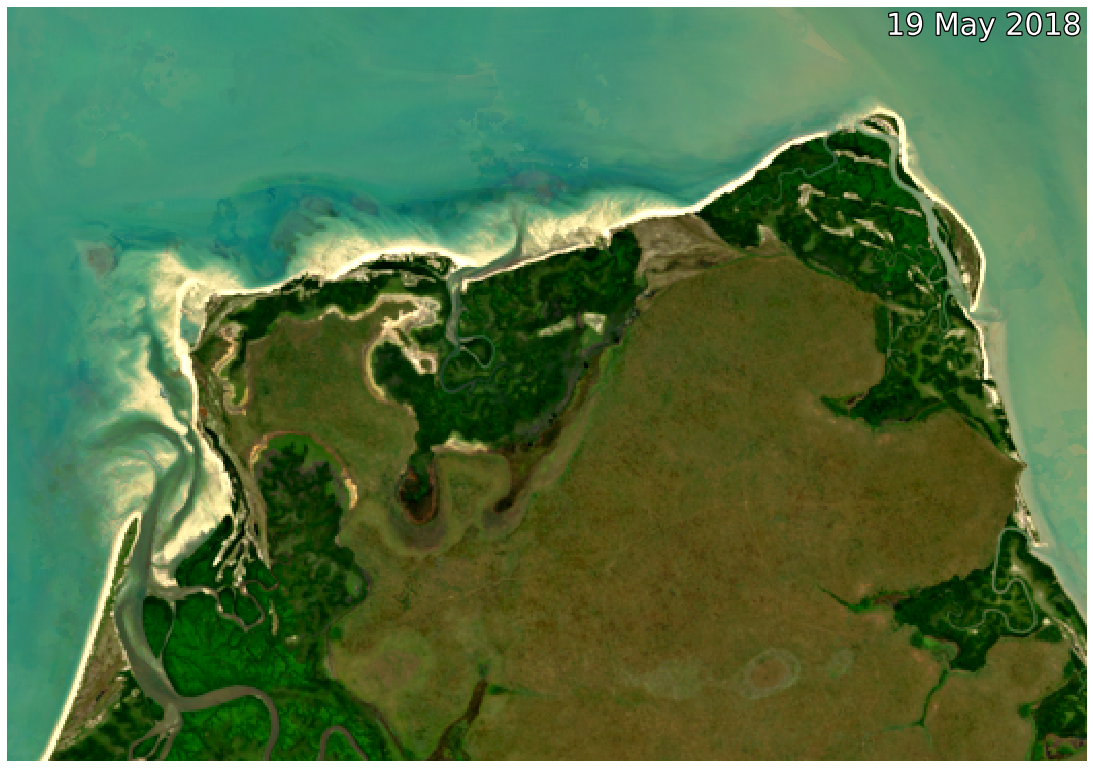

In [7]:
import numpy as np
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity

funcs_list = [lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
              lambda x: x**0.15,
              rescale_intensity,
              lambda x: unsharp_mask(x, radius=50, amount=0.5),
              lambda x: unsharp_mask(x, radius=5, amount=0.2)]
# funcs_list = None

xr_animation(ds=ds_rolling.isel(time=slice(5, -5)),
             bands=bands,
             interval=80,
             width_pixels=1080,
             percentile_stretch=(0.01, 0.995),
             image_proc_funcs=funcs_list,
             annotation_kwargs={'fontsize': 30},
#              limit=10,
            ) 

## DEA CoastLines animation

In [125]:
import geopandas as gpd
import pandas as pd
import matplotlib

# Get extent of satellite data
bbox = gpd.GeoDataFrame(geometry=[ds_ls.geobox.extent.geom],
                        crs=ds_ls.geobox.crs)  

# Load CoastLines data for subset and dissolve to year
deacl_gdf = gpd.read_file('/g/data/r78/DEACoastLines/DEACoastLines_coastlines_v0.3.0.shp', 
                          bbox=bbox)
deacl_gdf = gpd.overlay(deacl_gdf, bbox.to_crs(deacl_gdf.crs))
deacl_gdf = deacl_gdf.dissolve('year')

# Apply colours
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(deacl_gdf.index))
cmap = matplotlib.cm.get_cmap('inferno')
rgba = cmap(norm(deacl_gdf.reset_index().index))
deacl_gdf['color'] = list(rgba)
deacl_gdf['start_time'] = (pd.to_datetime(deacl_gdf.index) + 
                           pd.DateOffset(months=5))

Applying custom image processing functions


Exporting animation to FarquharInlet.mp4


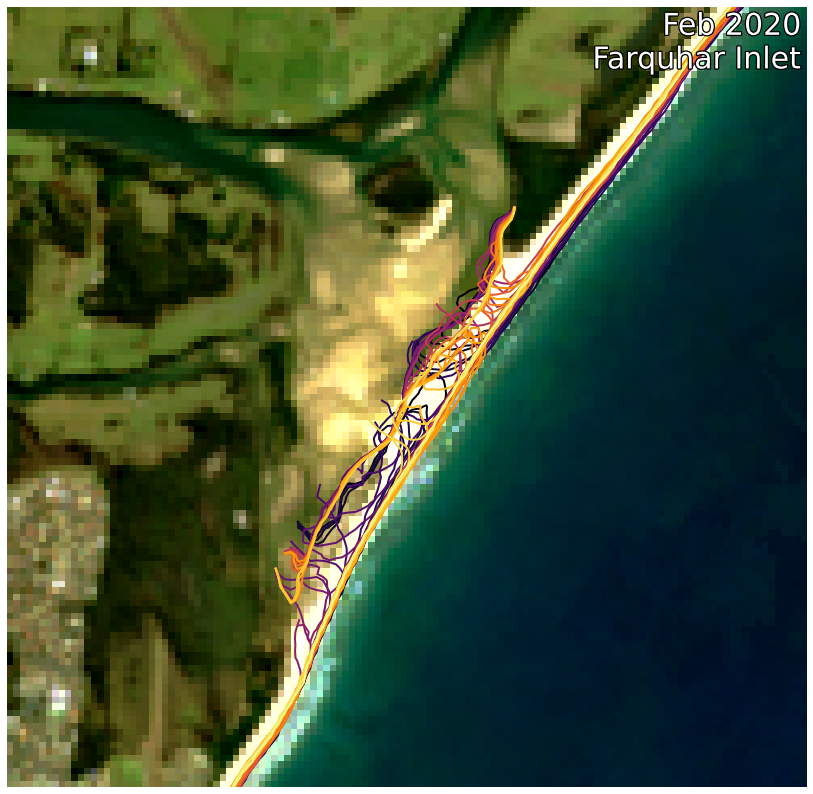

In [127]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity

funcs_list = [lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
              lambda x: x**0.5,
              rescale_intensity,
              lambda x: unsharp_mask(x, radius=50, amount=0.5),
              lambda x: unsharp_mask(x, radius=5, amount=0.3)
             ]
# funcs_list = None

xr_animation(output_path='FarquharInlet.mp4',
             ds=ds_rolling.isel(time=slice(5, -5)),
             show_text='Farquhar Inlet',
             bands=bands,
             interval=80,
             width_pixels=800,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             show_date='%b %Y',
             annotation_kwargs={'fontsize': 30},
             show_gdf=deacl_gdf,
             gdf_kwargs = {'linewidth': 2},
#              limit=10,
            ) 